In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 96
import numpy as np
import pandas as pd
import seaborn as sns

# import libraries for biological data analysis
from coolpuppy import coolpup
from coolpuppy.lib import numutils
from coolpuppy.lib.puputils import divide_pups
from coolpuppy import plotpup
import cooler
import bioframe
import cooltools
from cooltools import expected_cis, expected_trans
from cooltools.lib import plotting
from chromoscores.snipping import *


import warnings
warnings.filterwarnings('ignore')


### ctcf peaks

In [2]:
ctcf_path='/project/fudenber_735/collaborations/karissa_2022/2022_09_features_for_RNAseq/ChIP-seq_in_WT-parental-E14'
ctcf = bioframe.read_table(ctcf_path+'/CTCF_peaks_called_on_4reps_foundInatLeast2reps_noBlacklist.bed', schema='bed')

RAD21=bioframe.read_table(ctcf_path+'/RAD21_peaks_called_on_6reps_foundInatLeast3reps_noBlacklist.bed', schema='bed')
RAD21['mid']=(RAD21.end+RAD21.start)/2
ctcf['mid']=(ctcf.end+ctcf.start)/2

In [3]:
ctcf

,chrom,start,end,name,score,strand,mid
0,chr1,4142490,4142913,CTCF_4reps_peak_2,64.65743,NaN,4142701.5
1,chr1,4332483,4332832,CTCF_4reps_peak_5,39.08555,NaN,4332657.5
2,chr1,4346148,4346563,CTCF_4reps_peak_6,79.91960,NaN,4346355.5
3,chr1,4416660,4417109,CTCF_4reps_peak_8,96.79732,NaN,4416884.5
4,chr1,4491865,4492386,CTCF_4reps_peak_9,84.59853,NaN,4492125.5
...,...,...,...,...,...,...,...
45834,chrX,168673401,168673773,CTCF_4reps_peak_69563,33.27952,NaN,168673587.0
45835,chrX,169036508,169037081,CTCF_4reps_peak_69567,36.41209,NaN,169036794.5
45836,chrX,169085920,169086223,CTCF_4reps_peak_69568,26.15091,NaN,169086071.5
45837,chrY,872918,873242,CTCF_4reps_peak_69577,32.47781,NaN,873080.0


In [4]:
ctcf['quartile_score']=pd.qcut(ctcf['score'],4, labels=False) + 1

In [5]:
ctcf_quart=ctcf[ctcf['quartile_score']==4]

In [6]:
ctcf_quart

,chrom,start,end,name,score,strand,mid,quartile_score
3,chr1,4416660,4417109,CTCF_4reps_peak_8,96.79732,NaN,4416884.5,4
4,chr1,4491865,4492386,CTCF_4reps_peak_9,84.59853,NaN,4492125.5,4
31,chr1,7396871,7397626,CTCF_4reps_peak_52,105.31587,NaN,7397248.5,4
32,chr1,7398126,7398638,CTCF_4reps_peak_53,100.37192,NaN,7398382.0,4
37,chr1,9469388,9469849,CTCF_4reps_peak_60,98.75822,NaN,9469618.5,4
...,...,...,...,...,...,...,...,...
45756,chrX,159409277,159409678,CTCF_4reps_peak_69425,83.02445,NaN,159409477.5,4
45760,chrX,159532306,159532777,CTCF_4reps_peak_69433,128.08290,NaN,159532541.5,4
45768,chrX,159987852,159988452,CTCF_4reps_peak_69443,153.57147,NaN,159988152.0,4
45814,chrX,164269160,164269649,CTCF_4reps_peak_69520,92.93923,NaN,164269404.5,4


### ctcf from JASPAR data

In [7]:
direct='/project/fudenber_735/motifs/mm10/jaspar/MA0139.1.tsv.gz'

In [8]:
ctcfs_motif=bioframe.read_table(direct)

In [9]:
ctcfs_motif.head()

,0,1,2,3,4,5,6
0,chr10,3103662,3103681,CTCF,814,410,-
1,chr10,3108121,3108140,CTCF,859,504,-
2,chr10,3119020,3119039,CTCF,801,386,-
3,chr10,3124081,3124100,CTCF,807,397,-
4,chr10,3127081,3127100,CTCF,810,403,+


In [10]:
ctcf_motif=ctcfs_motif.rename(columns={0: 'chrom', 1: 'start',2:'end',3:'name',4:'score',5:'pval',6:'strand'})
ctcf_motif

,chrom,start,end,name,score,pval,strand
0,chr10,3103662,3103681,CTCF,814,410,-
1,chr10,3108121,3108140,CTCF,859,504,-
2,chr10,3119020,3119039,CTCF,801,386,-
3,chr10,3124081,3124100,CTCF,807,397,-
4,chr10,3127081,3127100,CTCF,810,403,+
...,...,...,...,...,...,...,...
825505,chrY,90829177,90829196,CTCF,842,465,+
825506,chrY,90839573,90839592,CTCF,804,392,+
825507,chrY,90839785,90839804,CTCF,885,565,-
825508,chrY,90839787,90839806,CTCF,842,465,+


In [11]:
ctcf_motif['quartile_score']=pd.qcut(ctcf_motif['score'],4,labels=False) + 1
ctcf_motif

,chrom,start,end,name,score,pval,strand,quartile_score
0,chr10,3103662,3103681,CTCF,814,410,-,2
1,chr10,3108121,3108140,CTCF,859,504,-,4
2,chr10,3119020,3119039,CTCF,801,386,-,1
3,chr10,3124081,3124100,CTCF,807,397,-,1
4,chr10,3127081,3127100,CTCF,810,403,+,2
...,...,...,...,...,...,...,...,...
825505,chrY,90829177,90829196,CTCF,842,465,+,4
825506,chrY,90839573,90839592,CTCF,804,392,+,1
825507,chrY,90839785,90839804,CTCF,885,565,-,4
825508,chrY,90839787,90839806,CTCF,842,465,+,4


In [12]:
ctcf_motif_quart=ctcf_motif[ctcf_motif['quartile_score']==4]
ctcf_motif_quart

,chrom,start,end,name,score,pval,strand,quartile_score
1,chr10,3108121,3108140,CTCF,859,504,-,4
6,chr10,3136802,3136821,CTCF,876,543,+,4
19,chr10,3202574,3202593,CTCF,844,470,-,4
24,chr10,3218832,3218851,CTCF,842,465,+,4
27,chr10,3229366,3229385,CTCF,869,527,+,4
...,...,...,...,...,...,...,...,...
825503,chrY,90828914,90828933,CTCF,861,506,+,4
825504,chrY,90829175,90829194,CTCF,885,565,-,4
825505,chrY,90829177,90829196,CTCF,842,465,+,4
825507,chrY,90839785,90839804,CTCF,885,565,-,4


### overlap

In [13]:
peaks_motifs = bioframe.overlap(ctcf,ctcf_motif,how='inner')

In [14]:
peaks_motifs = peaks_motifs[(peaks_motifs['chrom']!= 'chrX')&(peaks_motifs['chrom']!= 'chrY')]
peaks_motifs

,chrom,start,end,name,score,strand,mid,quartile_score,chrom_,start_,end_,name_,score_,pval_,strand_,quartile_score_
0,chr4,3420153,3420519,CTCF_4reps_peak_41668,32.81981,NaN,3420336.0,1,chr4,3420314,3420333,CTCF,875,539,-,4
1,chr4,3420153,3420519,CTCF_4reps_peak_41668,32.81981,NaN,3420336.0,1,chr4,3420513,3420532,CTCF,809,401,+,2
2,chr4,3607245,3607549,CTCF_4reps_peak_41670,24.71592,NaN,3607397.0,1,chr4,3607390,3607409,CTCF,840,462,+,4
3,chr4,3608327,3608715,CTCF_4reps_peak_41671,40.44050,NaN,3608521.0,2,chr4,3608530,3608549,CTCF,856,495,-,4
4,chr4,3608892,3609173,CTCF_4reps_peak_41672,18.99883,NaN,3609032.5,1,chr4,3609047,3609066,CTCF,926,680,+,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55068,chr6,89245317,89245698,CTCF_4reps_peak_53706,22.03795,NaN,89245507.5,1,chr6,89245314,89245333,CTCF,838,457,+,3
55069,chr6,108714432,108714810,CTCF_4reps_peak_54189,51.26492,NaN,108714621.0,2,chr6,108714421,108714440,CTCF,801,386,+,1
55070,chr6,113000920,113001312,CTCF_4reps_peak_54262,53.26836,NaN,113001116.0,2,chr6,113000914,113000933,CTCF,813,408,-,2
55071,chr6,122739910,122740410,CTCF_4reps_peak_54767,87.20881,NaN,122740160.0,4,chr6,122739906,122739925,CTCF,807,397,+,1


In [15]:
peaks_motifs[peaks_motifs['strand_']=='NAN']

,chrom,start,end,name,score,strand,mid,quartile_score,chrom_,start_,end_,name_,score_,pval_,strand_,quartile_score_


In [16]:
peaks_motifs=peaks_motifs.rename(columns={'strand':'strand_','strand_':'strand'})

In [17]:
peaks_motifs=peaks_motifs[['chrom','start','end','name','score','mid','quartile_score','strand']]
peaks_motifs

,chrom,start,end,name,score,mid,quartile_score,strand
0,chr4,3420153,3420519,CTCF_4reps_peak_41668,32.81981,3420336.0,1,-
1,chr4,3420153,3420519,CTCF_4reps_peak_41668,32.81981,3420336.0,1,+
2,chr4,3607245,3607549,CTCF_4reps_peak_41670,24.71592,3607397.0,1,+
3,chr4,3608327,3608715,CTCF_4reps_peak_41671,40.44050,3608521.0,2,-
4,chr4,3608892,3609173,CTCF_4reps_peak_41672,18.99883,3609032.5,1,+
...,...,...,...,...,...,...,...,...
55068,chr6,89245317,89245698,CTCF_4reps_peak_53706,22.03795,89245507.5,1,+
55069,chr6,108714432,108714810,CTCF_4reps_peak_54189,51.26492,108714621.0,2,+
55070,chr6,113000920,113001312,CTCF_4reps_peak_54262,53.26836,113001116.0,2,-
55071,chr6,122739910,122740410,CTCF_4reps_peak_54767,87.20881,122740160.0,4,+


### orientational overlap

In [18]:
peaks_motifs_right=peaks_motifs[peaks_motifs['strand']=='+']
peaks_motifs_left=peaks_motifs[peaks_motifs['strand']=='-']
peaks_motifs_dir_overlap=bioframe.overlap(peaks_motifs_right,peaks_motifs_left,how='inner')
peaks_motifs_dir_overlap

,chrom,start,end,name,score,mid,quartile_score,strand,chrom_,start_,end_,name_,score_,mid_,quartile_score_,strand_
0,chr4,3420153,3420519,CTCF_4reps_peak_41668,32.81981,3420336.0,1,+,chr4,3420153,3420519,CTCF_4reps_peak_41668,32.81981,3420336.0,1,-
1,chr4,3929536,3930014,CTCF_4reps_peak_41691,136.66945,3929775.0,4,+,chr4,3929536,3930014,CTCF_4reps_peak_41691,136.66945,3929775.0,4,-
2,chr4,6427404,6427790,CTCF_4reps_peak_41715,72.63385,6427597.0,3,+,chr4,6427404,6427790,CTCF_4reps_peak_41715,72.63385,6427597.0,3,-
3,chr4,6688569,6689002,CTCF_4reps_peak_41722,97.07346,6688785.5,4,+,chr4,6688569,6689002,CTCF_4reps_peak_41722,97.07346,6688785.5,4,-
4,chr4,6991080,6991581,CTCF_4reps_peak_41725,89.33720,6991330.5,4,+,chr4,6991080,6991581,CTCF_4reps_peak_41725,89.33720,6991330.5,4,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7785,chr6,148916710,148917240,CTCF_4reps_peak_55677,50.46438,148916975.0,2,+,chr6,148916710,148917240,CTCF_4reps_peak_55677,50.46438,148916975.0,2,-
7786,chr6,149057849,149058250,CTCF_4reps_peak_55695,37.16556,149058049.5,2,+,chr6,149057849,149058250,CTCF_4reps_peak_55695,37.16556,149058049.5,2,-
7787,chr6,149095451,149095807,CTCF_4reps_peak_55697,58.79952,149095629.0,3,+,chr6,149095451,149095807,CTCF_4reps_peak_55697,58.79952,149095629.0,3,-
7788,chr6,149132301,149132962,CTCF_4reps_peak_55701,50.66365,149132631.5,2,+,chr6,149132301,149132962,CTCF_4reps_peak_55701,50.66365,149132631.5,2,-


In [19]:
print(len(peaks_motifs_dir_overlap.index)/len(peaks_motifs.index),len(peaks_motifs_right.index)/len(peaks_motifs.index),len(peaks_motifs_left)/len(peaks_motifs.index))

0.1444598980064905 0.5008993973110802 0.4991006026889198


### overlap, quartile

In [20]:
peak_motif_quartile= bioframe.overlap(ctcf_quart,ctcf_motif_quart,how='inner')
peak_motif_quartile

,chrom,start,end,name,score,strand,mid,quartile_score,chrom_,start_,end_,name_,score_,pval_,strand_,quartile_score_
0,chr4,3780409,3780793,CTCF_4reps_peak_41675,83.76536,NaN,3780601.0,4,chr4,3780572,3780591,CTCF,879,551,-,4
1,chr4,3929536,3930014,CTCF_4reps_peak_41691,136.66945,NaN,3929775.0,4,chr4,3929768,3929787,CTCF,861,508,+,4
2,chr4,3967482,3968010,CTCF_4reps_peak_41692,154.36626,NaN,3967746.0,4,chr4,3967714,3967733,CTCF,917,654,-,4
3,chr4,6512961,6513398,CTCF_4reps_peak_41719,92.06953,NaN,6513179.5,4,chr4,6513171,6513190,CTCF,864,513,+,4
4,chr4,6688569,6689002,CTCF_4reps_peak_41722,97.07346,NaN,6688785.5,4,chr4,6688784,6688803,CTCF,845,472,-,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11723,chr6,147810710,147811098,CTCF_4reps_peak_55643,88.62326,NaN,147810904.0,4,chr6,147810916,147810935,CTCF,898,597,-,4
11724,chr6,148104186,148104604,CTCF_4reps_peak_55651,90.05859,NaN,148104395.0,4,chr6,148104404,148104423,CTCF,882,557,-,4
11725,chr6,148354332,148354781,CTCF_4reps_peak_55661,91.63938,NaN,148354556.5,4,chr6,148354569,148354588,CTCF,900,604,+,4
11726,chr6,148705656,148706146,CTCF_4reps_peak_55668,117.53876,NaN,148705901.0,4,chr6,148705889,148705908,CTCF,926,682,+,4


In [21]:
peaks_motif_quartile=peak_motif_quartile.rename(columns={'strand':'strand_','strand_':'strand'})
peaks_motif_quartile

,chrom,start,end,name,score,strand_,mid,quartile_score,chrom_,start_,end_,name_,score_,pval_,strand,quartile_score_
0,chr4,3780409,3780793,CTCF_4reps_peak_41675,83.76536,NaN,3780601.0,4,chr4,3780572,3780591,CTCF,879,551,-,4
1,chr4,3929536,3930014,CTCF_4reps_peak_41691,136.66945,NaN,3929775.0,4,chr4,3929768,3929787,CTCF,861,508,+,4
2,chr4,3967482,3968010,CTCF_4reps_peak_41692,154.36626,NaN,3967746.0,4,chr4,3967714,3967733,CTCF,917,654,-,4
3,chr4,6512961,6513398,CTCF_4reps_peak_41719,92.06953,NaN,6513179.5,4,chr4,6513171,6513190,CTCF,864,513,+,4
4,chr4,6688569,6689002,CTCF_4reps_peak_41722,97.07346,NaN,6688785.5,4,chr4,6688784,6688803,CTCF,845,472,-,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11723,chr6,147810710,147811098,CTCF_4reps_peak_55643,88.62326,NaN,147810904.0,4,chr6,147810916,147810935,CTCF,898,597,-,4
11724,chr6,148104186,148104604,CTCF_4reps_peak_55651,90.05859,NaN,148104395.0,4,chr6,148104404,148104423,CTCF,882,557,-,4
11725,chr6,148354332,148354781,CTCF_4reps_peak_55661,91.63938,NaN,148354556.5,4,chr6,148354569,148354588,CTCF,900,604,+,4
11726,chr6,148705656,148706146,CTCF_4reps_peak_55668,117.53876,NaN,148705901.0,4,chr6,148705889,148705908,CTCF,926,682,+,4


In [22]:
peaks_motif_quartile=peaks_motif_quartile[['chrom','start','end','name','score','mid','quartile_score','strand','score_','pval_']]

In [23]:
peaks_motif_quartile_right=peaks_motif_quartile[peaks_motif_quartile['strand']=='+']
peaks_motif_quartile_left=peaks_motif_quartile[peaks_motif_quartile['strand']=='-']

In [24]:
peaks_motif_quartile_dir_overlap=bioframe.overlap(peaks_motif_quartile_right,peaks_motif_quartile_left,how='inner')

In [25]:
print(len(peaks_motif_quartile_dir_overlap.index)/len(peaks_motif_quartile.index),len(peaks_motif_quartile_right.index)/len(peaks_motif_quartile.index),len(peaks_motif_quartile_left)/len(peak_motif_quartile.index))

0.0727319236016371 0.49948840381991816 0.5005115961800819


In [26]:
peaks_motif_quartile_dir_n_overlap=bioframe.subtract(peaks_motif_quartile,peaks_motif_quartile_dir_overlap)
peaks_motif_quartile_dir_n_overlap

,chrom,start,end,name,score,mid,quartile_score,strand,score_,pval_
0,chr4,3780409,3780793,CTCF_4reps_peak_41675,83.76536,3780601.0,4,-,879,551
1,chr4,3929536,3930014,CTCF_4reps_peak_41691,136.66945,3929775.0,4,+,861,508
2,chr4,3967482,3968010,CTCF_4reps_peak_41692,154.36626,3967746.0,4,-,917,654
3,chr4,6512961,6513398,CTCF_4reps_peak_41719,92.06953,6513179.5,4,+,864,513
4,chr4,8084921,8085352,CTCF_4reps_peak_41730,93.10840,8085136.5,4,-,857,499
...,...,...,...,...,...,...,...,...,...,...
10152,chr6,147810710,147811098,CTCF_4reps_peak_55643,88.62326,147810904.0,4,-,898,597
10153,chr6,148104186,148104604,CTCF_4reps_peak_55651,90.05859,148104395.0,4,-,882,557
10154,chr6,148354332,148354781,CTCF_4reps_peak_55661,91.63938,148354556.5,4,+,900,604
10155,chr6,148705656,148706146,CTCF_4reps_peak_55668,117.53876,148705901.0,4,+,926,682


In [27]:
print(len(peaks_motif_quartile_dir_n_overlap.index)/len(peaks_motif_quartile.index))

0.8660470668485676


In [28]:
1-0.8660470668485676

0.13395293315143242

In [29]:
alls=peaks_motif_quartile_dir_n_overlap

In [30]:
rs=alls[alls['strand']=='+']
ls=alls[alls['strand']=='-']    

In [31]:
over=bioframe.overlap(rs,ls,how='inner')

In [32]:
over

,chrom,start,end,name,score,mid,quartile_score,strand,score_,pval_,chrom_,start_,end_,name_,score_,mid_,quartile_score_,strand_,score__,pval__


### picking chromosomes 

In [33]:
peaks_motif_quartile = peaks_motif_quartile[(peaks_motif_quartile['chrom']!= 'chrX')&(peaks_motif_quartile['chrom']!= 'chrY')]
peaks_motif_quartile

,chrom,start,end,name,score,mid,quartile_score,strand,score_,pval_
0,chr4,3780409,3780793,CTCF_4reps_peak_41675,83.76536,3780601.0,4,-,879,551
1,chr4,3929536,3930014,CTCF_4reps_peak_41691,136.66945,3929775.0,4,+,861,508
2,chr4,3967482,3968010,CTCF_4reps_peak_41692,154.36626,3967746.0,4,-,917,654
3,chr4,6512961,6513398,CTCF_4reps_peak_41719,92.06953,6513179.5,4,+,864,513
4,chr4,6688569,6689002,CTCF_4reps_peak_41722,97.07346,6688785.5,4,-,845,472
...,...,...,...,...,...,...,...,...,...,...
11723,chr6,147810710,147811098,CTCF_4reps_peak_55643,88.62326,147810904.0,4,-,898,597
11724,chr6,148104186,148104604,CTCF_4reps_peak_55651,90.05859,148104395.0,4,-,882,557
11725,chr6,148354332,148354781,CTCF_4reps_peak_55661,91.63938,148354556.5,4,+,900,604
11726,chr6,148705656,148706146,CTCF_4reps_peak_55668,117.53876,148705901.0,4,+,926,682


In [34]:
np.unique(peaks_motif_quartile['chrom'])

array(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr3', 'chr4', 'chr5',
       'chr6', 'chr7', 'chr8', 'chr9'], dtype=object)

In [35]:
peaks_motifs = peaks_motifs[(peaks_motifs['chrom']!= 'chrX')&(peaks_motifs['chrom']!= 'chrY')]
peaks_motifs

,chrom,start,end,name,score,mid,quartile_score,strand
0,chr4,3420153,3420519,CTCF_4reps_peak_41668,32.81981,3420336.0,1,-
1,chr4,3420153,3420519,CTCF_4reps_peak_41668,32.81981,3420336.0,1,+
2,chr4,3607245,3607549,CTCF_4reps_peak_41670,24.71592,3607397.0,1,+
3,chr4,3608327,3608715,CTCF_4reps_peak_41671,40.44050,3608521.0,2,-
4,chr4,3608892,3609173,CTCF_4reps_peak_41672,18.99883,3609032.5,1,+
...,...,...,...,...,...,...,...,...
55068,chr6,89245317,89245698,CTCF_4reps_peak_53706,22.03795,89245507.5,1,+
55069,chr6,108714432,108714810,CTCF_4reps_peak_54189,51.26492,108714621.0,2,+
55070,chr6,113000920,113001312,CTCF_4reps_peak_54262,53.26836,113001116.0,2,-
55071,chr6,122739910,122740410,CTCF_4reps_peak_54767,87.20881,122740160.0,4,+


### importing experimental data 

In [36]:
# high-resolution reprocessed publically-available data from Bonev et al. 2017
res = 10_000
bonev_file = '/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_ES.mm10.mapq_30.1000.mcool'
bonev_cooler = cooler.Cooler(bonev_file+'::resolutions/'+str(res))
view_df_bonev = cooltools.lib.make_cooler_view(bonev_cooler)[:19]

In [37]:
# data from Liu& deWit et al. 
prefix_dir_liu = '/project/fudenber_735/GEO/liu_deWit_GSE181848/'
cooler_prefix_liu = prefix_dir_liu
sample_dict_liu ={
    'Wapl-0h':'GSM5512837_HiC.01_WAPL_0h.mcool',
    'Wapl-6h':'GSM5512838_HiC.02_WAPL_6h.mcool'
}
sample='Wapl-6h'
mcool_path_liu =  cooler_prefix_liu + sample_dict_liu[sample]
liu_cooler = cooler.Cooler(mcool_path_liu+'::resolutions/'+str(res))
view_df_liu = cooltools.lib.make_cooler_view(liu_cooler)[:19]

In [38]:
# data from Liu 2021
prefix_dir_liu_new = '/project/fudenber_735/GEO/liu_deWit_2021_GSE135180/distiller-mm10/results/coolers_library/'
cooler_prefix_liu_new = prefix_dir_liu_new
sample_dict_liu_new ={
    'Wapl-0h_new':'liu_wapl0h.mm10.mapq_30.1000.mcool',
    'Wapl-24h_new':'liu_wapl24h.mm10.mapq_30.1000.mcool'
}
sample='Wapl-24h_new'
mcool_path_liu_new =  cooler_prefix_liu_new + sample_dict_liu_new[sample]
liu_new_cooler = cooler.Cooler(mcool_path_liu_new+'::resolutions/'+str(res))
view_df_liu_new = cooltools.lib.make_cooler_view(liu_new_cooler)[:19]

### piling up

In [39]:
sites=peaks_motif_quartile.copy()
flank_bp=100_000
sites

,chrom,start,end,name,score,mid,quartile_score,strand,score_,pval_
0,chr4,3780409,3780793,CTCF_4reps_peak_41675,83.76536,3780601.0,4,-,879,551
1,chr4,3929536,3930014,CTCF_4reps_peak_41691,136.66945,3929775.0,4,+,861,508
2,chr4,3967482,3968010,CTCF_4reps_peak_41692,154.36626,3967746.0,4,-,917,654
3,chr4,6512961,6513398,CTCF_4reps_peak_41719,92.06953,6513179.5,4,+,864,513
4,chr4,6688569,6689002,CTCF_4reps_peak_41722,97.07346,6688785.5,4,-,845,472
...,...,...,...,...,...,...,...,...,...,...
11723,chr6,147810710,147811098,CTCF_4reps_peak_55643,88.62326,147810904.0,4,-,898,597
11724,chr6,148104186,148104604,CTCF_4reps_peak_55651,90.05859,148104395.0,4,-,882,557
11725,chr6,148354332,148354781,CTCF_4reps_peak_55661,91.63938,148354556.5,4,+,900,604
11726,chr6,148705656,148706146,CTCF_4reps_peak_55668,117.53876,148705901.0,4,+,926,682


In [40]:
peaks_motifs_quartile=peaks_motif_quartile[['chrom','start','end','score','strand']]
sites=peaks_motifs_quartile.copy()

In [41]:
sites

,chrom,start,end,score,strand
0,chr4,3780409,3780793,83.76536,-
1,chr4,3929536,3930014,136.66945,+
2,chr4,3967482,3968010,154.36626,-
3,chr4,6512961,6513398,92.06953,+
4,chr4,6688569,6689002,97.07346,-
...,...,...,...,...,...
11723,chr6,147810710,147811098,88.62326,-
11724,chr6,148104186,148104604,90.05859,-
11725,chr6,148354332,148354781,91.63938,+
11726,chr6,148705656,148706146,117.53876,+


### On-diagonal pile up

INFO:coolpuppy:('chr1', 'chr1'): 644
INFO:coolpuppy:Total number of piled up windows: 644


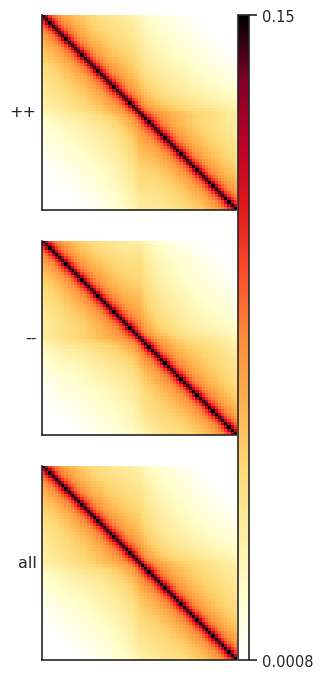

In [42]:
pup = coolpup.pileup(bonev_cooler, sites, features_format='bed', view_df=view_df_bonev[:1], local=True,
                        by_strand=True,
                        flank=300_000, min_diag=0)
fg = plotpup.plot(pup,
             rows='orientation', row_order=['++', '--','all'],
             score=False, cmap='fall', scale='log', sym=False, vmax=0.15,vmin=0.0008,
             height=3)
plt.show()

In [43]:
pup['data'][0].shape

(61, 61)

### isolation score, observed over expected


In [44]:
import chromoscores.maputils as chrmap
import chromoscores.snipping as chrsnip
import chromoscores.scorefunctions as chrscores
import seaborn as sns

In [45]:
# Bonev et al 2017

In [ ]:
view_df = view_df[:1]

INFO:coolpuppy:('chr1', 'chr1'): 644
INFO:coolpuppy:Total number of piled up windows: 644


i is 0
score is 1.3056607369211515
i is 1
score is 1.2990050452541384
i is 2
score is 1.3022071989227648


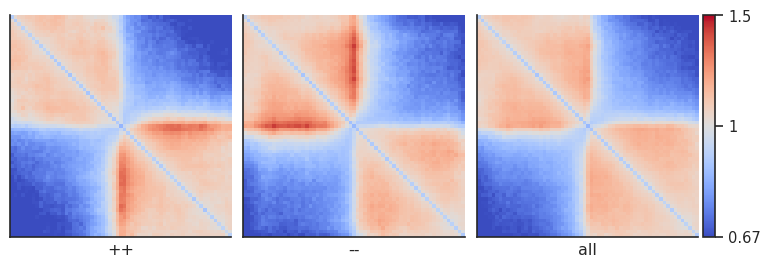

In [46]:
sites=peaks_motifs_quartile.copy()
clr = bonev_cooler
pseudocount = 10./clr.info['sum']
expected = expected_cis(
    clr,
    ignore_diags=0,
    view_df=view_df_bonev[:1],
    chunksize=1000000)

pup = coolpup.pileup(clr, sites, features_format='bed', expected_df=expected,view_df=view_df_bonev[:1], local=True,
                    by_strand=True,
                    flank=300_000, min_diag=0
                    )
#pup=pup[pup['orientation']=='all']
scr=[]
delta_val = 1
diag_offset_val = 10
max_distance_val = 30
for i in range(len(pup['data'])):
    print('i is %s'%i)
    #a,b,pile_c=get_isolated_regions(pup['data'][i],24,1,3,15)
    pile = pup['data'][i]
    score=chrscores.isolation_score(pile,delta=delta_val,diag_offset=diag_offset_val,max_dist=max_distance_val,
                                    snippet_shapes='triangle',
                                    pseudo_count=pseudocount)
    scr.append(score)
    print('score is %s'%score)
    #print('average is %s'%(np.mean(a[a>0])/np.mean(b[b>0])))
    

plotpup.plot(pup,
         cols='orientation', col_order=['++', '--','all'],
         score=False, cmap='coolwarm', scale='log', sym=True, vmax=1.5,
         height=3)


plt.savefig('ondiagonal_for_bonev_top_quart.pdf')
plt.show()

INFO:coolpuppy:('chr1', 'chr1'): 3456
INFO:coolpuppy:Total number of piled up windows: 3456


i is 0
score is 1.2236093644738941
i is 1
score is 1.2225265386379913
i is 2
score is 1.223059137666681


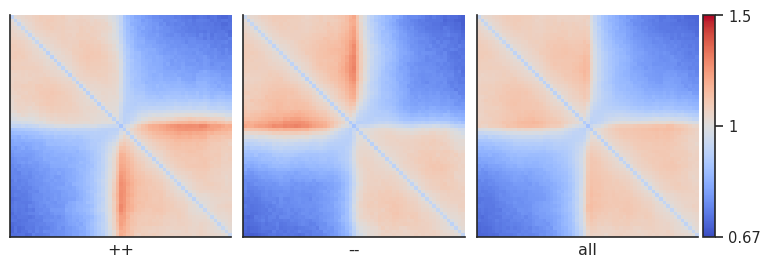

In [47]:
sites=peaks_motifs.copy()
clr = bonev_cooler
pseudocount = 10./clr.info['sum']
expected = expected_cis(
    clr,
    ignore_diags=0,
    view_df=view_df_bonev[:1],
    chunksize=1000000)

pup = coolpup.pileup(clr, sites, features_format='bed', expected_df=expected,view_df=view_df_bonev[:1], local=True,
                    by_strand=True,
                    flank=300_000, min_diag=0
                    )
#pup=pup[pup['orientation']=='all']
scr=[]
delta_val = 1
diag_offset_val = 10
max_distance_val = 30
for i in range(len(pup['data'])):
    print('i is %s'%i)
    #a,b,pile_c=get_isolated_regions(pup['data'][i],24,1,3,15)
    pile = pup['data'][i]
    score=chrscores.isolation_score(pile,delta=delta_val,diag_offset=diag_offset_val,max_dist=max_distance_val,
                                    snippet_shapes='triangle',
                                    pseudo_count=pseudocount)
    scr.append(score)
    print('score is %s'%score)
    #print('average is %s'%(np.mean(a[a>0])/np.mean(b[b>0])))
    

plotpup.plot(pup,
         cols='orientation', col_order=['++', '--','all'],
         score=False, cmap='coolwarm', scale='log', sym=True, vmax=1.5,
         height=3)


plt.savefig('ondiagonal_for_bonev.pdf')
plt.show()

In [48]:
# Liu et al

INFO:coolpuppy:('chr1', 'chr1'): 644
INFO:coolpuppy:Total number of piled up windows: 644


i is 0
score is 1.3280762418922298
i is 1
score is 1.3189262010265963
i is 2
score is 1.3234659142482363


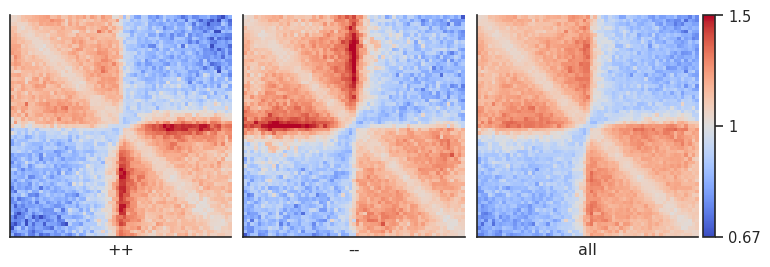

INFO:coolpuppy:('chr1', 'chr1'): 644
INFO:coolpuppy:Total number of piled up windows: 644


i is 0
score is 1.2894722045032698
i is 1
score is 1.275880612780001
i is 2
score is 1.2827533056628504


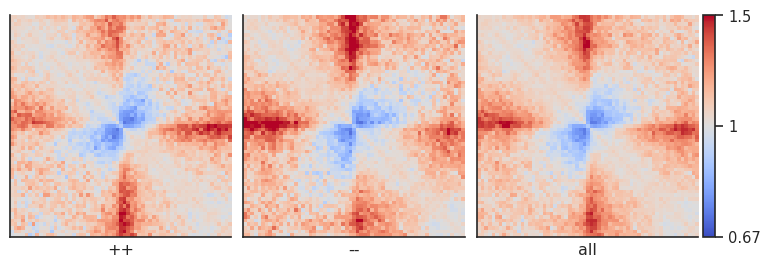

In [49]:
sites=peaks_motifs_quartile.copy()

for sample in sample_dict_liu:
    mcool_path_liu =  cooler_prefix_liu + sample_dict_liu[sample]
    liu_cooler = cooler.Cooler(mcool_path_liu+'::resolutions/'+str(res))
    view_df_liu = cooltools.lib.make_cooler_view(liu_cooler)[:19]
    
    clr = liu_cooler
    pseudocount = 10./clr.info['sum']
    
    expected = expected_cis(
        clr,
        ignore_diags=0,
        view_df=view_df_liu[:1],
        chunksize=1000000)
    
    pup = coolpup.pileup(clr, sites, features_format='bed', expected_df=expected,view_df=view_df_liu[:1], local=True,
                        by_strand=True,
                        flank=300_000, min_diag=0
                        )

    scr=[]
    delta_val = 1
    diag_offset_val = 10
    max_distance_val = 30
    for i in range(len(pup['data'])):
        print('i is %s'%i)
        pile = pup['data'][i]
        score=chrscores.isolation_score(pile,delta=delta_val,diag_offset=diag_offset_val,max_dist=max_distance_val,
                                        snippet_shapes='triangle',
                                        pseudo_count=pseudocount)
        scr.append(score)
        print('score is %s'%score)
        #print('average is %s'%(np.mean(a[a>0])/np.mean(b[b>0])))
        
    
    plotpup.plot(pup,
             cols='orientation', col_order=['++', '--','all'],
             score=False, cmap='coolwarm', scale='log', sym=True, vmax=1.5,
             height=3)
    
    
    plt.savefig('ondiagonal_for_liu_%s_top_quart.pdf'%sample)
    plt.show()

INFO:coolpuppy:('chr1', 'chr1'): 3456
INFO:coolpuppy:Total number of piled up windows: 3456


i is 0
score is 1.2233677984290405
i is 1
score is 1.233695115738459
i is 2
score is 1.2284978460871296


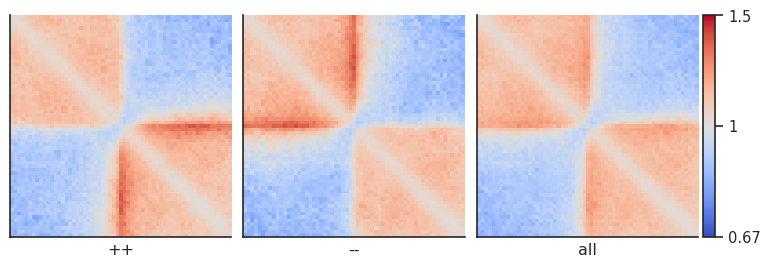

INFO:coolpuppy:('chr1', 'chr1'): 3456
INFO:coolpuppy:Total number of piled up windows: 3456


i is 0
score is 1.1971112866414475
i is 1
score is 1.1990486044678785
i is 2
score is 1.198059562004909


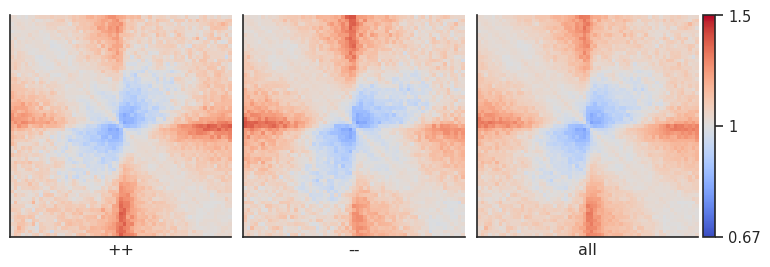

In [50]:
sites=peaks_motifs.copy()

for sample in sample_dict_liu:
    mcool_path_liu =  cooler_prefix_liu + sample_dict_liu[sample]
    liu_cooler = cooler.Cooler(mcool_path_liu+'::resolutions/'+str(res))
    view_df_liu = cooltools.lib.make_cooler_view(liu_cooler)[:19]
    
    clr = liu_cooler
    pseudocount = 10./clr.info['sum']
    
    expected = expected_cis(
        clr,
        ignore_diags=0,
        view_df=view_df_liu[:1],
        chunksize=1000000)
    
    pup = coolpup.pileup(clr, sites, features_format='bed', expected_df=expected,view_df=view_df_liu[:1], local=True,
                        by_strand=True,
                        flank=300_000, min_diag=0
                        )

    scr=[]
    delta_val = 1
    diag_offset_val = 10
    max_distance_val = 30
    for i in range(len(pup['data'])):
        print('i is %s'%i)
        pile = pup['data'][i]
        score=chrscores.isolation_score(pile,delta=delta_val,diag_offset=diag_offset_val,max_dist=max_distance_val,
                                        snippet_shapes='triangle',
                                        pseudo_count=pseudocount)
        scr.append(score)
        print('score is %s'%score)
        #print('average is %s'%(np.mean(a[a>0])/np.mean(b[b>0])))
        
    
    plotpup.plot(pup,
             cols='orientation', col_order=['++', '--','all'],
             score=False, cmap='coolwarm', scale='log', sym=True, vmax=1.5,
             height=3)
    
    
    plt.savefig('ondiagonal_for_liu_%s.pdf'%sample)
    plt.show()

In [51]:
# Liu et al 2021

INFO:coolpuppy:('chr1', 'chr1'): 644
INFO:coolpuppy:Total number of piled up windows: 644


i is 0
score is 1.3336546428615654
i is 1
score is 1.3180452195652985
i is 2
score is 1.32575140883152


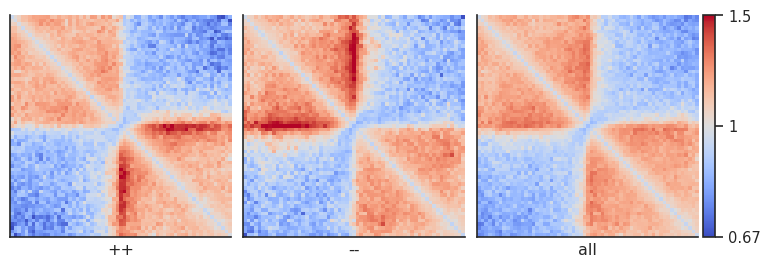

INFO:coolpuppy:('chr1', 'chr1'): 644
INFO:coolpuppy:Total number of piled up windows: 644


i is 0
score is 1.2929365259992396
i is 1
score is 1.273578263173856
i is 2
score is 1.2833795777370935


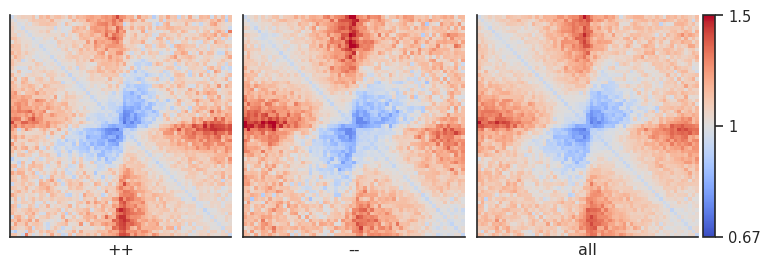

In [52]:
sites=peaks_motifs_quartile.copy()

for sample in sample_dict_liu_new:
    mcool_path_liu_new =  cooler_prefix_liu_new + sample_dict_liu_new[sample]
    liu_cooler_new = cooler.Cooler(mcool_path_liu_new+'::resolutions/'+str(res))
    view_df_liu_new = cooltools.lib.make_cooler_view(liu_cooler_new)[:19]
    
    clr = liu_cooler_new
    pseudocount = 10./clr.info['sum']
    
    expected = expected_cis(
        clr,
        ignore_diags=0,
        view_df=view_df_liu_new[:1],
        chunksize=1000000)
    
    pup = coolpup.pileup(clr, sites, features_format='bed', expected_df=expected,view_df=view_df_liu_new[:1], local=True,
                        by_strand=True,
                        flank=300_000, min_diag=0
                        )

    scr=[]
    delta_val = 1
    diag_offset_val = 10
    max_distance_val = 30
    for i in range(len(pup['data'])):
        print('i is %s'%i)
        pile = pup['data'][i]
        score=chrscores.isolation_score(pile,delta=delta_val,diag_offset=diag_offset_val,max_dist=max_distance_val,
                                        snippet_shapes='triangle',
                                        pseudo_count=pseudocount)
        scr.append(score)
        print('score is %s'%score)
        #print('average is %s'%(np.mean(a[a>0])/np.mean(b[b>0])))
        
    
    plotpup.plot(pup,
             cols='orientation', col_order=['++', '--','all'],
             score=False, cmap='coolwarm', scale='log', sym=True, vmax=1.5,
             height=3)
    
    
    plt.savefig('ondiagonal_for_liu_new_%s_topo_quart.pdf'%sample)
    plt.show()

INFO:coolpuppy:('chr1', 'chr1'): 3456
INFO:coolpuppy:Total number of piled up windows: 3456


i is 0
score is 1.2241403157403714
i is 1
score is 1.2352543011186428
i is 2
score is 1.229616268552034


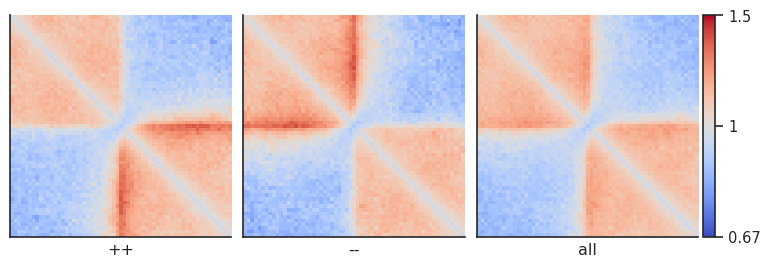

INFO:coolpuppy:('chr1', 'chr1'): 3456
INFO:coolpuppy:Total number of piled up windows: 3456


i is 0
score is 1.1881726244315487
i is 1
score is 1.1948543106754455
i is 2
score is 1.1914655936548622


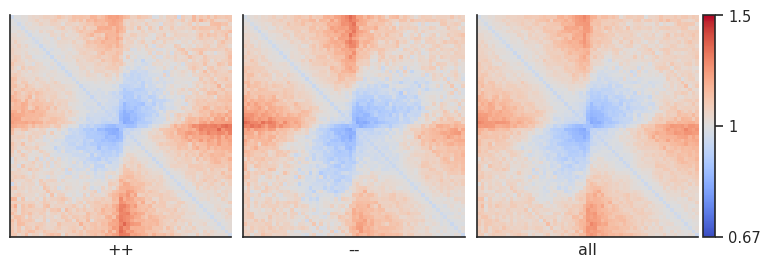

In [53]:
sites=peaks_motifs.copy()

for sample in sample_dict_liu_new:
    mcool_path_liu_new =  cooler_prefix_liu_new + sample_dict_liu_new[sample]
    liu_cooler_new = cooler.Cooler(mcool_path_liu_new+'::resolutions/'+str(res))
    view_df_liu_new = cooltools.lib.make_cooler_view(liu_cooler_new)[:19]
    
    clr = liu_cooler_new
    pseudocount = 10./clr.info['sum']
    
    expected = expected_cis(
        clr,
        ignore_diags=0,
        view_df=view_df_liu_new[:1],
        chunksize=1000000)
    
    pup = coolpup.pileup(clr, sites, features_format='bed', expected_df=expected,view_df=view_df_liu_new[:1], local=True,
                        by_strand=True,
                        flank=300_000, min_diag=0
                        )

    scr=[]
    delta_val = 1
    diag_offset_val = 10
    max_distance_val = 30
    for i in range(len(pup['data'])):
        print('i is %s'%i)
        pile = pup['data'][i]
        score=chrscores.isolation_score(pile,delta=delta_val,diag_offset=diag_offset_val,max_dist=max_distance_val,
                                        snippet_shapes='triangle',
                                        pseudo_count=pseudocount)
        scr.append(score)
        print('score is %s'%score)
        #print('average is %s'%(np.mean(a[a>0])/np.mean(b[b>0])))
        
    
    plotpup.plot(pup,
             cols='orientation', col_order=['++', '--','all'],
             score=False, cmap='coolwarm', scale='log', sym=True, vmax=1.5,
             height=3)
    
    
    plt.savefig('ondiagonal_for_liu_new_%s.pdf'%sample)
    plt.show()

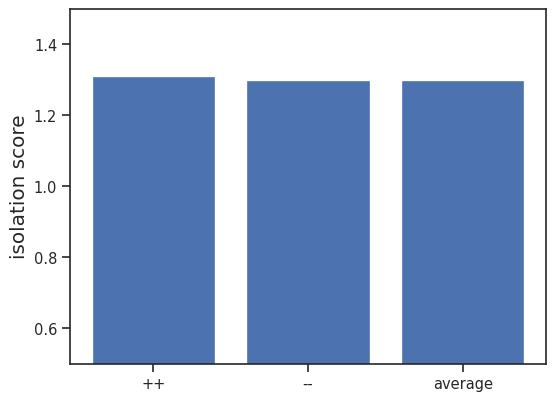

In [68]:
a = ['++','--','average']
b = [1.31,1.3,1.3]
plt.bar(a,b)
plt.ylabel('isolation score',fontsize = 15)
plt.savefig('isoscore_bar_chart_experiment.png')
plt.ylim(0.5,1.5)
plt.show()

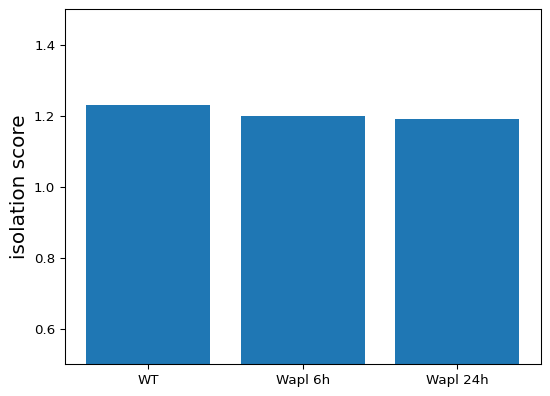

In [6]:
a = ['WT','Wapl 6h','Wapl 24h']
b = [1.23,1.20,1.19]
plt.bar(a,b)
plt.ylabel('isolation score',fontsize = 15)
plt.savefig('isoscore_bar_chart_experiment.pdf')
plt.ylim(0.5,1.5)
plt.show()

INFO:coolpuppy:('chr1', 'chr1'): 3456
INFO:coolpuppy:Total number of piled up windows: 3456


i is 0
score is 1.2236093644738941
i is 1
score is 1.2225265386379913
i is 2
score is 1.223059137666681


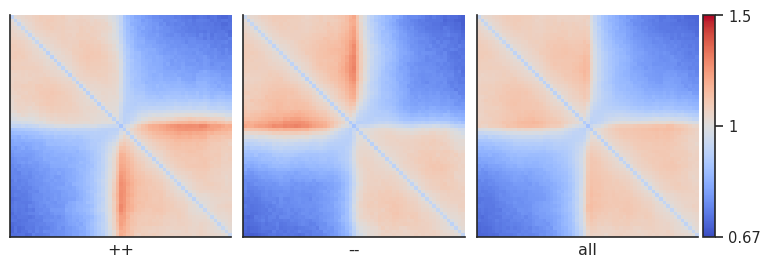

In [78]:
pseudocount = 10./clr.info['sum']
sites=peaks_motifs.copy()
clr = bonev_cooler

expected = expected_cis(
    clr,
    ignore_diags=0,
    view_df=view_df[:1],
    chunksize=1000000)

pup = coolpup.pileup(clr, sites, features_format='bed', expected_df=expected,view_df=view_df[:1], local=True,
                    by_strand=True,
                    flank=300_000, min_diag=0
                    )
#pup=pup[pup['orientation']=='all']
scr=[]
delta_val = 1
diag_offset_val = 10
max_distance_val = 30
for i in range(len(pup['data'])):
    print('i is %s'%i)
    #a,b,pile_c=get_isolated_regions(pup['data'][i],24,1,3,15)
    pile = pup['data'][i]
    score=chrscores.isolation_score(pile,delta=delta_val,diag_offset=diag_offset_val,max_dist=max_distance_val,
                                    snippet_shapes='triangle',
                                    pseudo_count=pseudocount)
    scr.append(score)
    print('score is %s'%score)
    #print('average is %s'%(np.mean(a[a>0])/np.mean(b[b>0])))
    

plotpup.plot(pup,
         cols='orientation', col_order=['++', '--','all'],
         score=False, cmap='coolwarm', scale='log', sym=True, vmax=1.5,
         height=3)



plt.show()

i is 0
i is 1
i is 2
score is 1.223059137666681


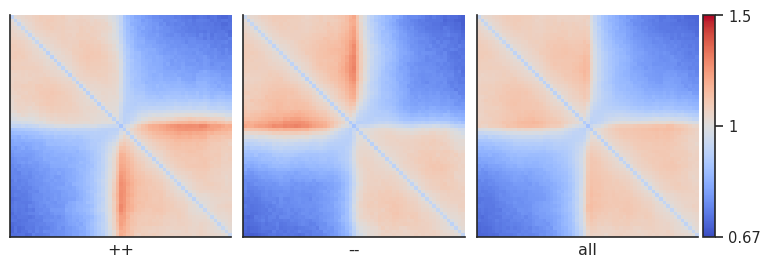

In [85]:
scr=[]
delta_val = 1
diag_offset_val = 10
max_distance_val = 30
for i in range(len(pup['data'])):
    print('i is %s'%i)
    #a,b,pile_c=get_isolated_regions(pup['data'][i],24,1,3,15)
    pile = pup['data'][i]
    score=chrscores.isolation_score(pile,delta=delta_val,diag_offset=diag_offset_val,max_dist=max_distance_val,
                                    snippet_shapes='triangle',
                                    pseudo_count=pseudocount)
    scr.append(score)
print('score is %s'%score)
    #print('average is %s'%(np.mean(a[a>0])/np.mean(b[b>0])))
    

plotpup.plot(pup,
         cols='orientation', col_order=['++', '--','all'],
         score=False, cmap='coolwarm', scale='log', sym=True, vmax=1.5,
         height=3)


plt.savefig('ondiagonal.png')
plt.show()

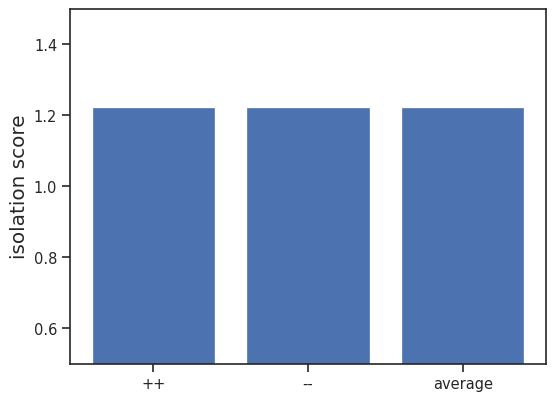

In [86]:
a = ['++','--','average']
b = [1.223,1.223,1.223]
plt.bar(a,b)
plt.ylabel('isolation score',fontsize = 15)
plt.savefig('isoscore_bar_chart_experiment.png')
plt.ylim(0.5,1.5)
plt.show()

### isolation score, observed

In [ ]:
# bonev 2017

INFO:coolpuppy:('chr1', 'chr1'): 644
INFO:coolpuppy:Total number of piled up windows: 644


i is 0
score is 1.2978878102940479
i is 1
score is 1.290037527237851
i is 2
score is 1.2938391943799679


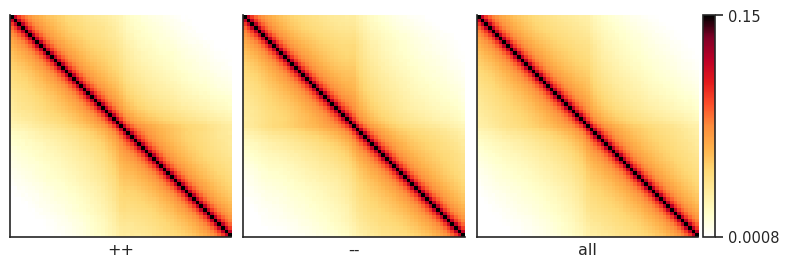

In [48]:
sites=peaks_motifs_quartile.copy()
clr = bonev_cooler
pseudocount = 10./clr.info['sum']
#expected = expected_cis(
#    clr,
#    ignore_diags=0,
#    view_df=view_df_bonev[:1],
#    chunksize=1000000)

pup = coolpup.pileup(clr, sites, features_format='bed', view_df=view_df_bonev[:1], local=True,
                    by_strand=True,
                    flank=300_000, min_diag=0
                    )
scr=[]
delta_val = 1
diag_offset_val = 10
max_distance_val = 30
for i in range(len(pup['data'])):
    print('i is %s'%i)
    pile = pup['data'][i]
    score=chrscores.isolation_score(pile,delta=delta_val,diag_offset=diag_offset_val,max_dist=max_distance_val,
                                    snippet_shapes='triangle',
                                    pseudo_count=pseudocount)
    scr.append(score)
    print('score is %s'%score)
    #print('average is %s'%(np.mean(a[a>0])/np.mean(b[b>0])))
    

plotpup.plot(pup,
         cols='orientation', col_order=['++', '--','all'],
         score=False, cmap='fall', scale='log', sym=False, vmax=0.15,vmin=0.0008, 
         height=3)


plt.savefig('ondiagonal_for_bonev_top_quart_observed.pdf')
plt.show()

In [49]:
# Liu et al

INFO:coolpuppy:('chr1', 'chr1'): 644
INFO:coolpuppy:Total number of piled up windows: 644


i is 0
score is 1.3221615086461385
i is 1
score is 1.3122252287375928
i is 2
score is 1.3171699060976076


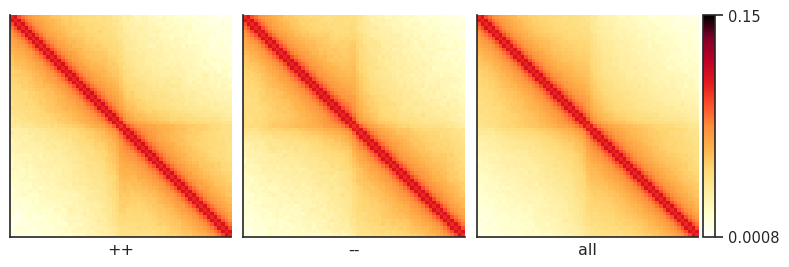

INFO:coolpuppy:('chr1', 'chr1'): 644
INFO:coolpuppy:Total number of piled up windows: 644


i is 0
score is 1.2848464926844119
i is 1
score is 1.2717099640785792
i is 2
score is 1.2783521059340595


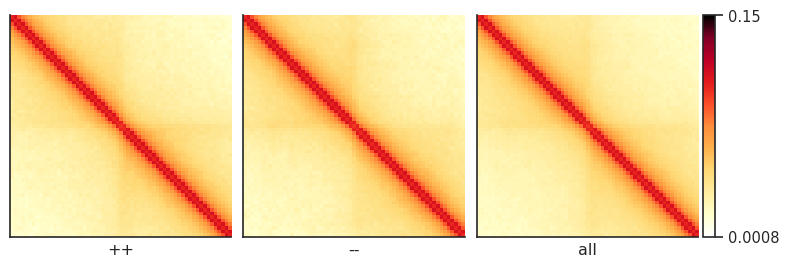

In [51]:
sites=peaks_motifs_quartile.copy()

for sample in sample_dict_liu:
    mcool_path_liu =  cooler_prefix_liu + sample_dict_liu[sample]
    liu_cooler = cooler.Cooler(mcool_path_liu+'::resolutions/'+str(res))
    view_df_liu = cooltools.lib.make_cooler_view(liu_cooler)[:19]
    
    clr = liu_cooler
    pseudocount = 10./clr.info['sum']
    
#    expected = expected_cis(
#        clr,
#        ignore_diags=0,
#        view_df=view_df_liu[:1],
#        chunksize=1000000)
    
    pup = coolpup.pileup(clr, sites, features_format='bed', view_df=view_df_liu[:1], local=True,
                        by_strand=True,
                        flank=300_000, min_diag=0
                        )

    scr=[]
    delta_val = 1
    diag_offset_val = 10
    max_distance_val = 30
    for i in range(len(pup['data'])):
        print('i is %s'%i)
        pile = pup['data'][i]
        score=chrscores.isolation_score(pile,delta=delta_val,diag_offset=diag_offset_val,max_dist=max_distance_val,
                                        snippet_shapes='triangle',
                                        pseudo_count=pseudocount)
        scr.append(score)
        print('score is %s'%score)
        #print('average is %s'%(np.mean(a[a>0])/np.mean(b[b>0])))
        
    
    plotpup.plot(pup,
             cols='orientation', col_order=['++', '--','all'],
             score=False, cmap='fall', scale='log', sym=False, vmax=0.15,vmin=0.0008, 
             height=3)
    
    
    plt.savefig('ondiagonal_for_liu_%s_top_quart_observed.pdf'%sample)
    plt.show()

INFO:coolpuppy:('chr1', 'chr1'): 644
INFO:coolpuppy:Total number of piled up windows: 644


i is 0
score is 1.327884056507995
i is 1
score is 1.3116330605566953
i is 2
score is 1.3196593428168397


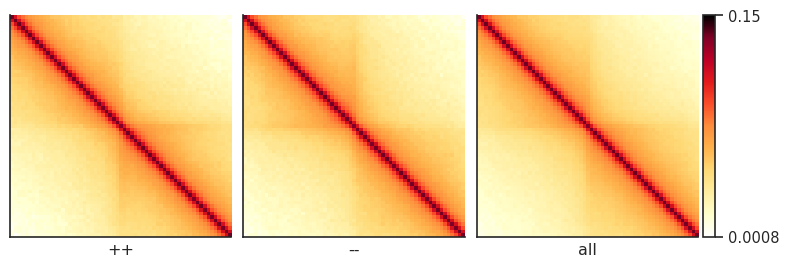

INFO:coolpuppy:('chr1', 'chr1'): 644
INFO:coolpuppy:Total number of piled up windows: 644


i is 0
score is 1.2908117570771975
i is 1
score is 1.2722466430875279
i is 2
score is 1.281642468778127


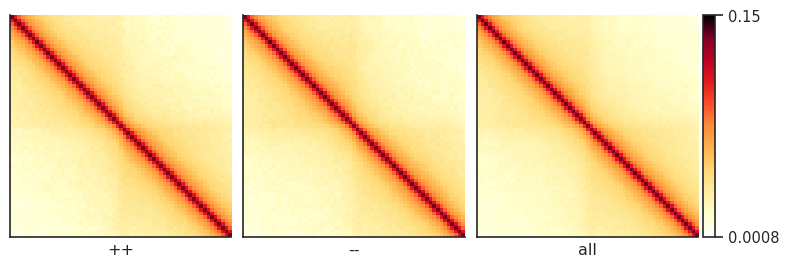

In [54]:
sites=peaks_motifs_quartile.copy()

for sample in sample_dict_liu_new:
    mcool_path_liu_new =  cooler_prefix_liu_new + sample_dict_liu_new[sample]
    liu_cooler_new = cooler.Cooler(mcool_path_liu_new+'::resolutions/'+str(res))
    view_df_liu_new = cooltools.lib.make_cooler_view(liu_cooler_new)[:19]
    
    clr = liu_cooler_new
    pseudocount = 10./clr.info['sum']
    
#    expected = expected_cis(
#        clr,
#        ignore_diags=0,
#        view_df=view_df_liu_new[:1],
#        chunksize=1000000)
    
    pup = coolpup.pileup(clr, sites, features_format='bed',view_df=view_df_liu_new[:1], local=True,
                        by_strand=True,
                        flank=300_000, min_diag=0
                        )

    scr=[]
    delta_val = 1
    diag_offset_val = 10
    max_distance_val = 30
    for i in range(len(pup['data'])):
        print('i is %s'%i)
        pile = pup['data'][i]
        score=chrscores.isolation_score(pile,delta=delta_val,diag_offset=diag_offset_val,max_dist=max_distance_val,
                                        snippet_shapes='triangle',
                                        pseudo_count=pseudocount)
        scr.append(score)
        print('score is %s'%score)
        #print('average is %s'%(np.mean(a[a>0])/np.mean(b[b>0])))
        
    
    plotpup.plot(pup,
             cols='orientation', col_order=['++', '--','all'],
             score=False, cmap='fall', scale='log', sym=False, vmax=0.15,vmin=0.0008,
             height=3)
    
    
    plt.savefig('ondiagonal_for_liu_new_%s_topo_quart_observed.pdf'%sample)
    plt.show()

INFO:coolpuppy:('chr1', 'chr1'): 3456
INFO:coolpuppy:Total number of piled up windows: 3456


i is 0
score is 1.2207258995949342
i is 1
score is 1.2301712270941474
i is 2
score is 1.2253773965049457


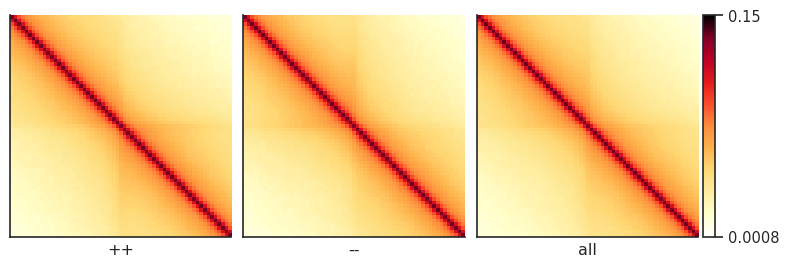

INFO:coolpuppy:('chr1', 'chr1'): 3456
INFO:coolpuppy:Total number of piled up windows: 3456


i is 0
score is 1.1862391089652997
i is 1
score is 1.192872619018182
i is 2
score is 1.1895106495971677


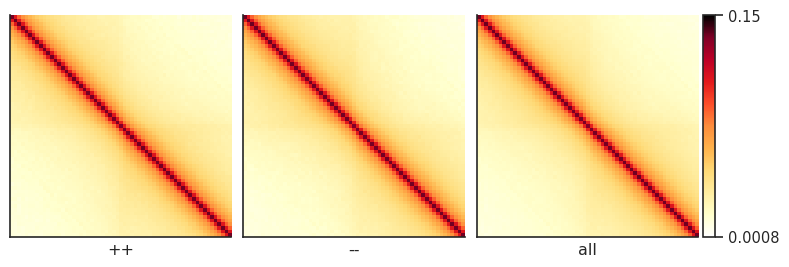

In [55]:
sites=peaks_motifs.copy()

for sample in sample_dict_liu_new:
    mcool_path_liu_new =  cooler_prefix_liu_new + sample_dict_liu_new[sample]
    liu_cooler_new = cooler.Cooler(mcool_path_liu_new+'::resolutions/'+str(res))
    view_df_liu_new = cooltools.lib.make_cooler_view(liu_cooler_new)[:19]
    
    clr = liu_cooler_new
    pseudocount = 10./clr.info['sum']
    
#    expected = expected_cis(
#        clr,
#        ignore_diags=0,
#        view_df=view_df_liu_new[:1],
#        chunksize=1000000)
    
    pup = coolpup.pileup(clr, sites, features_format='bed',view_df=view_df_liu_new[:1], local=True,
                        by_strand=True,
                        flank=300_000, min_diag=0
                        )

    scr=[]
    delta_val = 1
    diag_offset_val = 10
    max_distance_val = 30
    for i in range(len(pup['data'])):
        print('i is %s'%i)
        pile = pup['data'][i]
        score=chrscores.isolation_score(pile,delta=delta_val,diag_offset=diag_offset_val,max_dist=max_distance_val,
                                        snippet_shapes='triangle',
                                        pseudo_count=pseudocount)
        scr.append(score)
        print('score is %s'%score)
        #print('average is %s'%(np.mean(a[a>0])/np.mean(b[b>0])))
        
    
    plotpup.plot(pup,
             cols='orientation', col_order=['++', '--','all'],
             score=False, cmap='fall', scale='log', sym=False, vmax=0.15,vmin=0.0008,
             height=3)
    
    
    plt.savefig('ondiagonal_for_liu_new_%s_observed.pdf'%sample)
    plt.show()